In [1]:
#GAN
import numpy as np
import pandas as pd
import random 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn import preprocessing as p
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import seaborn as snspip

def load_and_preprocess_data(file_name):
    df = pd.read_csv(file_name)
    print("Original DataFrame shape:", df.shape)
    column_names = df.columns  

    dropped_columns = df.columns[df.nunique() == 1]  # Get the column names of the dropped columns
    df = df.drop(columns=dropped_columns)
    print("Dropped columns:", dropped_columns.tolist())  # Print the column names as a list

    # Save dropped column names to a new CSV file
    dropped_columns_df = pd.DataFrame(dropped_columns)  # Create a DataFrame from the dropped column names
    dropped_columns_df.to_csv('dropped_columns.csv', index=False, header=False)  # Save to CSV without index and header

    print("After dropping columns with one unique value:", df.shape)
    df = df.dropna()
    print("After dropping NaN values:", df.shape)
    column_names = df.columns  # Update column names after dropping columns
    
    return df, column_names

# Load and preprocess data
df, column_names = load_and_preprocess_data('/Users/r/Documents/SAPIENTAI/UNET_conda/Data/training_data.csv')
numpy_samples = df.to_numpy()

scaler = MinMaxScaler()

numpy_samples = scaler.fit_transform(numpy_samples) #scales 0 to 1 per column 

# Plot first 100 rows
num_rows_to_plot = 50
selected_rows = numpy_samples[:num_rows_to_plot]

def plot_data(dataset, cols=5):
    num_samples = len(dataset)
    plt.figure(figsize=(20, 2 * (num_samples // cols + 1)))
    for i, data in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.plot(data)
        # plt.scatter(range(len(data)), data)  # Use scatter plot instead of plot
        point_count = len(data)
        plt.title(f'Original Row {i+1} (Count: {point_count})')  # Display point count in the title
        plt.xticks(np.arange(0, len(data), 50))
        plt.xlabel('Index')

plot_data(selected_rows, cols=5)
plt.tight_layout()
plt.show()



# Calculate square root of the number of columns to be used as the image size
n = numpy_samples.shape[1]
image_size = int(np.sqrt(n))

# Increase image size to next power of 2
while image_size & (image_size - 1) != 0:  # Using bitwise AND to check if image_size is a power of 2
    image_size += 1

padded_image_size = image_size ** 2

gray_images = []

# For each sample in the numpy_samples, convert the row into a grayscale image with padding
for sample in numpy_samples:
    padded_sample = np.pad(sample, (0, padded_image_size - n), mode='constant')  # Pad the sample
    reshaped_image = padded_sample.reshape(image_size, image_size)  # Reshape the padded sample into an image
    gray_images.append(reshaped_image)  

gray_images_tensor = [torch.from_numpy(img) for img in gray_images]

# Stack all the tensors into a single tensor
stacked_tensor = torch.stack(gray_images_tensor)
dataset = TensorDataset(stacked_tensor)

print("Dataset not reshaped =", dataset.tensors[0].shape)


# Reshape the dataset to [1, n_padded, n_padded] and create dataloader
dataset_reshaped = torch.reshape(dataset.tensors[0], (len(numpy_samples), 1, int(np.sqrt(padded_image_size)), int(np.sqrt(padded_image_size))))
print("Dataset reshaped =", dataset_reshaped.shape)

batch_size = 32
dataloader = DataLoader(dataset_reshaped, batch_size=batch_size, shuffle=True, drop_last=True)


ImportError: cannot import name 'Image' from 'PIL' (unknown location)

In [ ]:
import torch
from torch import nn
from torch.optim import Adam

class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=1):
        super().__init__()
        #main part: generator blocks progressively upsample the input 
        # until it reaches the desired size (16x16) and the desired number of channels (1)
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, 512, kernel_size=4, stride=1, padding=0),  # Output: 4x4
            self.make_gen_block(512, 256, kernel_size=4, stride=2, padding=1),  # Output: 8x8
            self.make_gen_block(256, channels, kernel_size=4, stride=2, padding=1, final_layer=True),  # Output: 16x16
        )

# ConvTranspose2d layer upsamples the input
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        # Sigmoid activation to squash values between 0 and 1
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Sigmoid(),
            )
# takes noise and feeds thru network
    def forward(self, noise):
        noise = noise.view(len(noise), -1, 1, 1)  # reshape the noise to (Batch_size, z_dim, 1, 1)
        return self.gen(noise)



class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        # Does the opposite; progressively downsamples until it becomes 2x2 and 1 output channel
        self.disc = nn.Sequential(
            self.make_disc_block(channels, 64, kernel_size=4, stride=2, padding=1),  # Input: 16x16, Output: 8x8
            self.make_disc_block(64, 128, kernel_size=4, stride=2, padding=1),  # Input: 8x8, Output: 4x4
            self.make_disc_block(128, 1, kernel_size=4, stride=2, padding=1, final_layer=True),  # Input: 4x4, Output: 2x2
            nn.Flatten(), # Flatten the results to create a single output node
            nn.Linear(4, 1) # A single output node
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            #Conv2d layer downsalples the input
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.LeakyReLU(0.2, inplace=True)
            )

    def forward(self, image):
        return self.disc(image)


# Initialize Generator and Discriminator
gen = Generator(z_dim=100)
disc = Discriminator()

# Define parameters
lr = 0.0001
betas = (0.5, 0.999)
gen_opt = Adam(gen.parameters(), lr=lr, betas=betas)
disc_opt = Adam(disc.parameters(), lr=lr, betas=betas)

criterion = nn.BCEWithLogitsLoss()

n_epochs = 2000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Send the model to device
gen = gen.to(device)
disc = disc.to(device)

#training loop
for epoch in range(n_epochs):
    for real in dataloader:
        real = real.to(device)

        # Update discriminator
        disc_opt.zero_grad()
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake = gen(z) # Generate a batch of images from the noise
        real_pred = disc(real.float())  # Convert real to float
        fake_pred = disc(fake.detach().float())  # Convert fake to float
        disc_loss = criterion(real_pred, torch.ones_like(real_pred)) + criterion(fake_pred, torch.zeros_like(fake_pred))
        disc_loss.backward()
        disc_opt.step()

        # Update generator
        gen_opt.zero_grad()
        gen_loss = criterion(disc(fake.float()), torch.ones_like(fake_pred))  # Convert fake to float
        gen_loss.backward()
        gen_opt.step()
    
    if epoch % 50 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}] | Gen Loss: {gen_loss.item()} | Disc Loss: {disc_loss.item()}")


Epoch [1/2000] | Gen Loss: 0.5616279244422913 | Disc Loss: 1.3778828382492065
Epoch [51/2000] | Gen Loss: 1.4400335550308228 | Disc Loss: 0.6603227853775024
Epoch [101/2000] | Gen Loss: 2.373765230178833 | Disc Loss: 0.3292290270328522
Epoch [151/2000] | Gen Loss: 3.2085986137390137 | Disc Loss: 0.16591966152191162
Epoch [201/2000] | Gen Loss: 3.2089362144470215 | Disc Loss: 0.17905697226524353
Epoch [251/2000] | Gen Loss: 3.575875759124756 | Disc Loss: 0.16224023699760437
Epoch [301/2000] | Gen Loss: 4.0345377922058105 | Disc Loss: 0.20378440618515015
Epoch [351/2000] | Gen Loss: 3.5686917304992676 | Disc Loss: 0.0967918336391449
Epoch [401/2000] | Gen Loss: 4.294344425201416 | Disc Loss: 0.12102709710597992
Epoch [451/2000] | Gen Loss: 4.719731330871582 | Disc Loss: 0.06450575590133667
Epoch [501/2000] | Gen Loss: 5.218444347381592 | Disc Loss: 0.047791942954063416
Epoch [551/2000] | Gen Loss: 4.830257415771484 | Disc Loss: 0.06047052890062332
Epoch [601/2000] | Gen Loss: 4.889645576

In [ ]:
gen = gen.eval()
synthetic_images = []

# Generate synthetic samples
n_samples = 600
z = torch.randn(n_samples, 100, 1, 1).to(device)  # Generate random noise
synthetic_samples = gen(z).detach().cpu()

print("Synthetic Samples =", synthetic_samples.shape)

# Convert synthetic samples to a NumPy array
synthetic_samples = synthetic_samples.cpu().numpy()

# Reshape the synthetic samples to their original shape
synthetic_samples_reshaped = synthetic_samples.reshape(-1, n_padded)[:, :n]

print("Synthetic Samples Unpadded =", synthetic_samples_reshaped.shape)

# Remove padding from synthetic samples
synthetic_samples_unpadded = []
for sample in synthetic_samples_reshaped:
    unpadded_sample = sample[:n].reshape(-1)  # Remove padding by taking only the original dimensions
    synthetic_samples_unpadded.append(unpadded_sample)

print("Synthetic Samples Reshaped =", unpadded_sample.shape)

# Convert synthetic samples to a DataFrame and save as CSV
synthetic_df = pd.DataFrame(synthetic_samples_unpadded, columns=column_names)
synthetic_df.to_csv('v13_synthetic_samples.csv', index=False)


Synthetic Samples = torch.Size([600, 1, 16, 16])
Synthetic Samples Unpadded = (600, 201)
Synthetic Samples Reshaped = (201,)


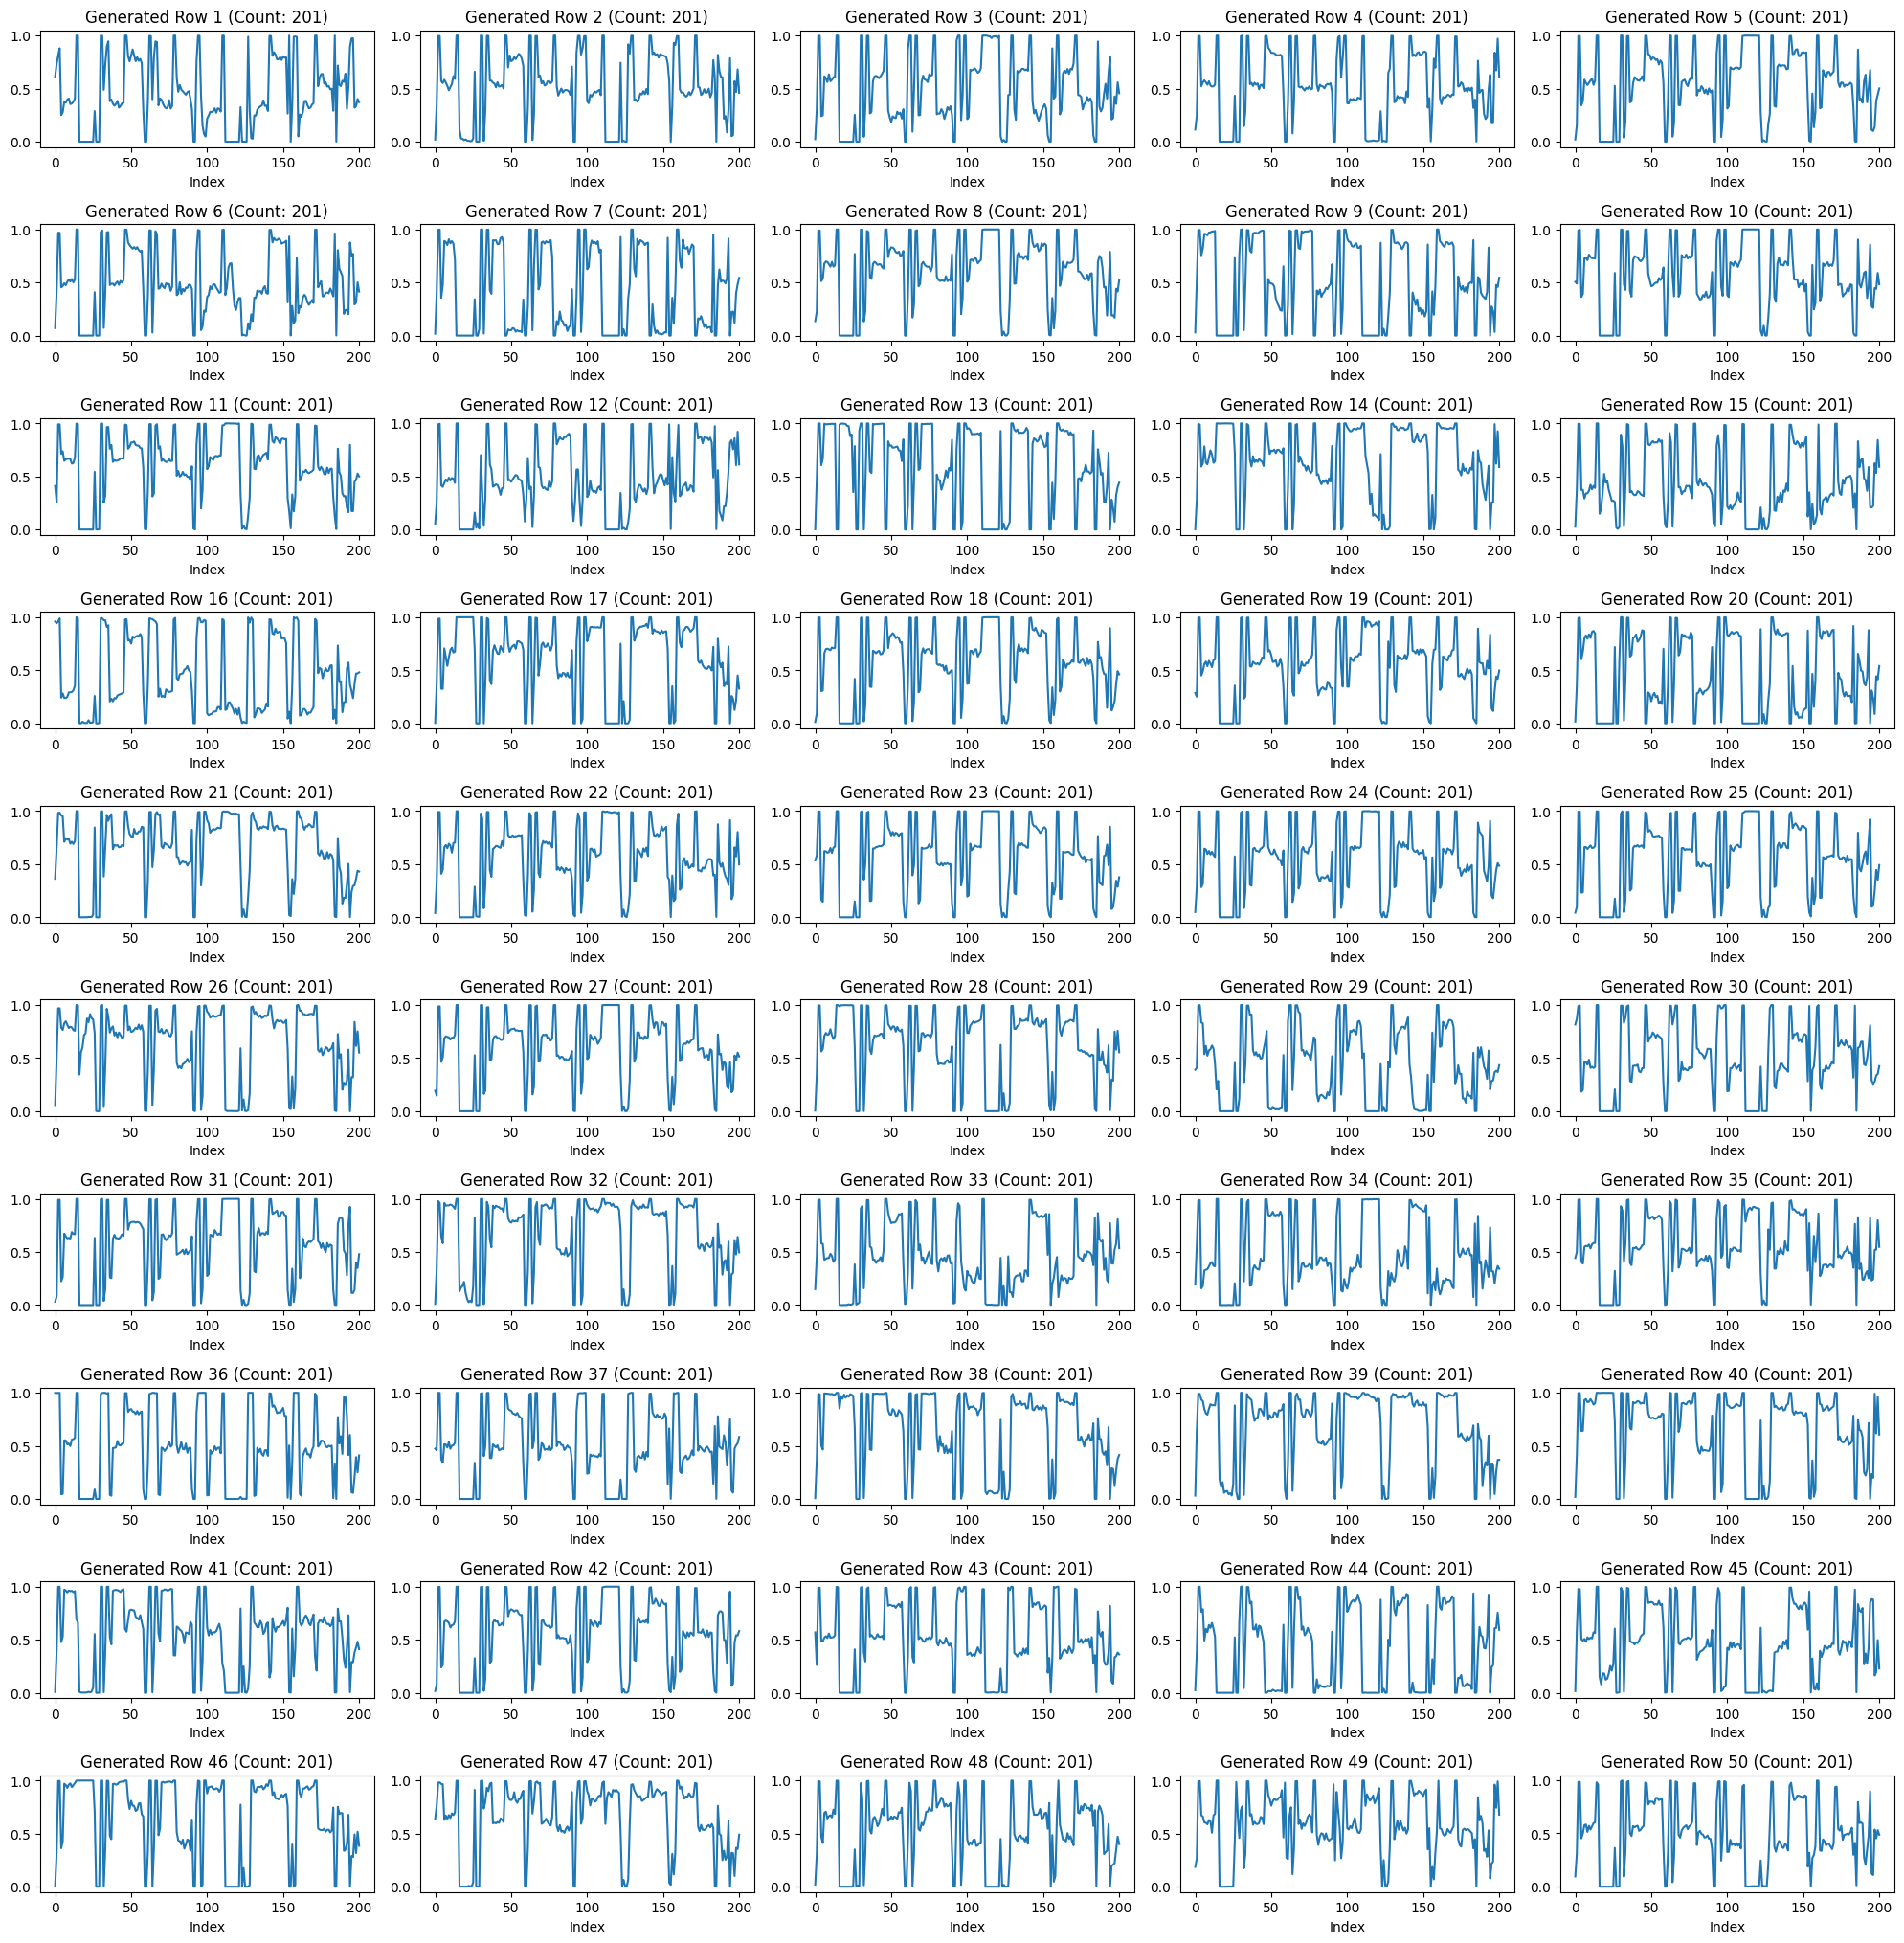

In [ ]:
# df1 = pd.read_csv('v13_synthetic_samples.csv')
# df2 = pd.read_csv('scaled_data.csv')



# Load generated dataset
dataset = pd.read_csv('v13_synthetic_samples.csv')

# Select the desired number of rows to plot
num_rows_to_plot = 50
selected_rows = dataset[:num_rows_to_plot].values


def plot_data(dataset, cols=5):
    num_samples = len(dataset)
    plt.figure(figsize=(20, 2 * (num_samples // cols + 1)))
    for i, data in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.plot(data)
        # plt.scatter(range(len(data)), data)  # Use scatter plot instead of plot
        point_count = len(data)
        plt.title(f'Generated Row {i+1} (Count: {point_count})') 
        plt.xticks(np.arange(0, len(data), 50))
        plt.xlabel('Index')

plot_data(selected_rows, cols=5)
plt.tight_layout()
plt.show()

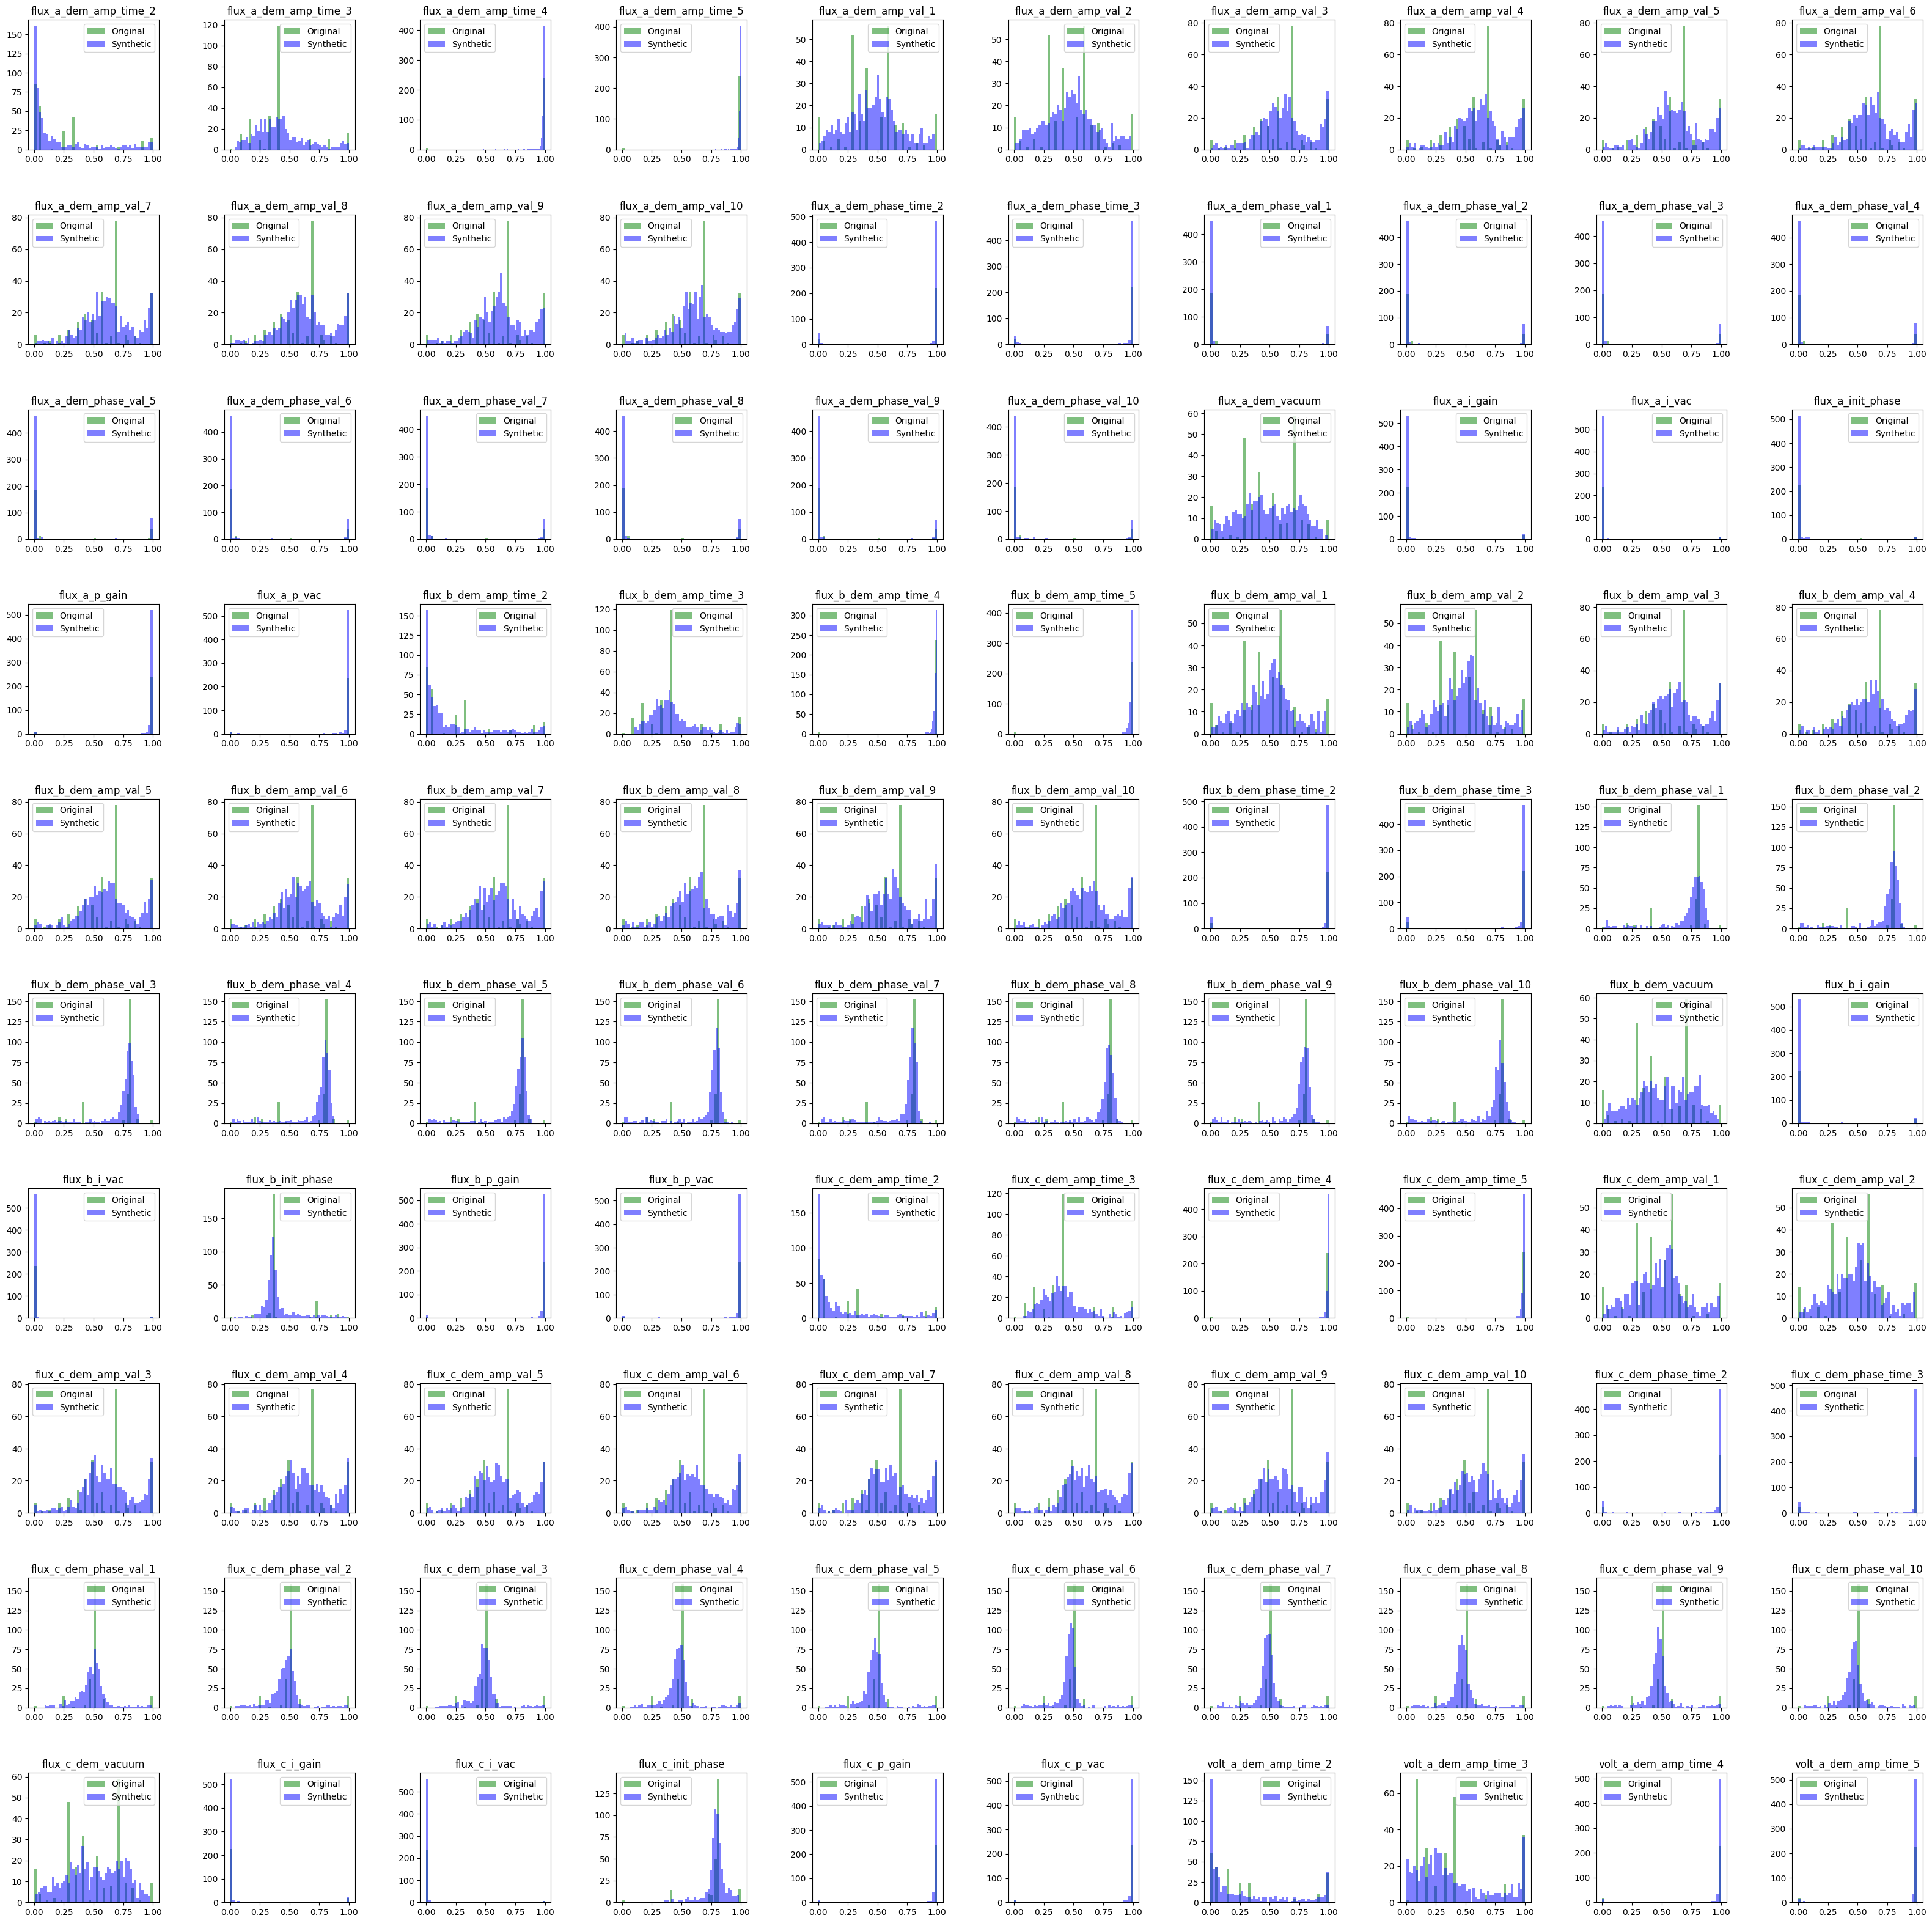

In [ ]:

# Read data from CSV files
original_samples = pd.read_csv('scaled_data.csv')
synthetic_samples = pd.read_csv('v13_synthetic_samples.csv')
original_samples = original_samples.loc[:, original_samples.nunique() != 1].dropna()
#synthetic_samples = synthetic_samples.loc[:, synthetic_samples.nunique() != 1]

# scaler = MinMaxScaler()

# # Scale original_samples and synthetic_samples
# original_samples_scaled = pd.DataFrame(scaler.fit_transform(original_samples), columns=original_samples.columns)
# synthetic_samples_scaled = pd.DataFrame(scaler.fit_transform(synthetic_samples), columns=synthetic_samples.columns)

df_train = original_samples
df_generated = synthetic_samples




num_cols = 100

# Number of rows and columns in the subplot grid
grid_size = int(num_cols**0.5)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(40, 40))

# Adjust the vertical distance between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(num_cols):
    row = i // grid_size
    col = i % grid_size

    column = original_samples.columns[i]

    axes[row, col].hist(original_samples[column], bins=50, alpha=0.5, label='Original', color='green')
    axes[row, col].hist(synthetic_samples[column], bins=50, alpha=0.5, label='Synthetic', color='blue')

    axes[row, col].legend()
    axes[row, col].set_title(column)

fig.savefig("v13_histograms.png", dpi=300)

In [1]:
#Plot quantiles
import matplotlib.pyplot as plt
column_name = 'flux_c_i_vac'

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

fig, axs = plt.subplots(2, figsize=(10,12))

# Plot quantiles for training data
for i, q in enumerate(quantiles):
    df_train[column_name].rolling(50).quantile(q).plot(ax=axs[0], label=f'Train Q{int(q*100)}', color=plt.cm.viridis(i/len(quantiles)))

# Plot quantiles for generated data
for i, q in enumerate(quantiles):
    df_generated[column_name].rolling(50).quantile(q).plot(ax=axs[1], label=f'Generated Q{int(q*100)}', color=plt.cm.viridis(i/len(quantiles)))

axs[0].set_title('Training Data')
axs[1].set_title('Generated Data')
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_ylim([0, 1])
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


ImportError: cannot import name 'Image' from 'PIL' (unknown location)

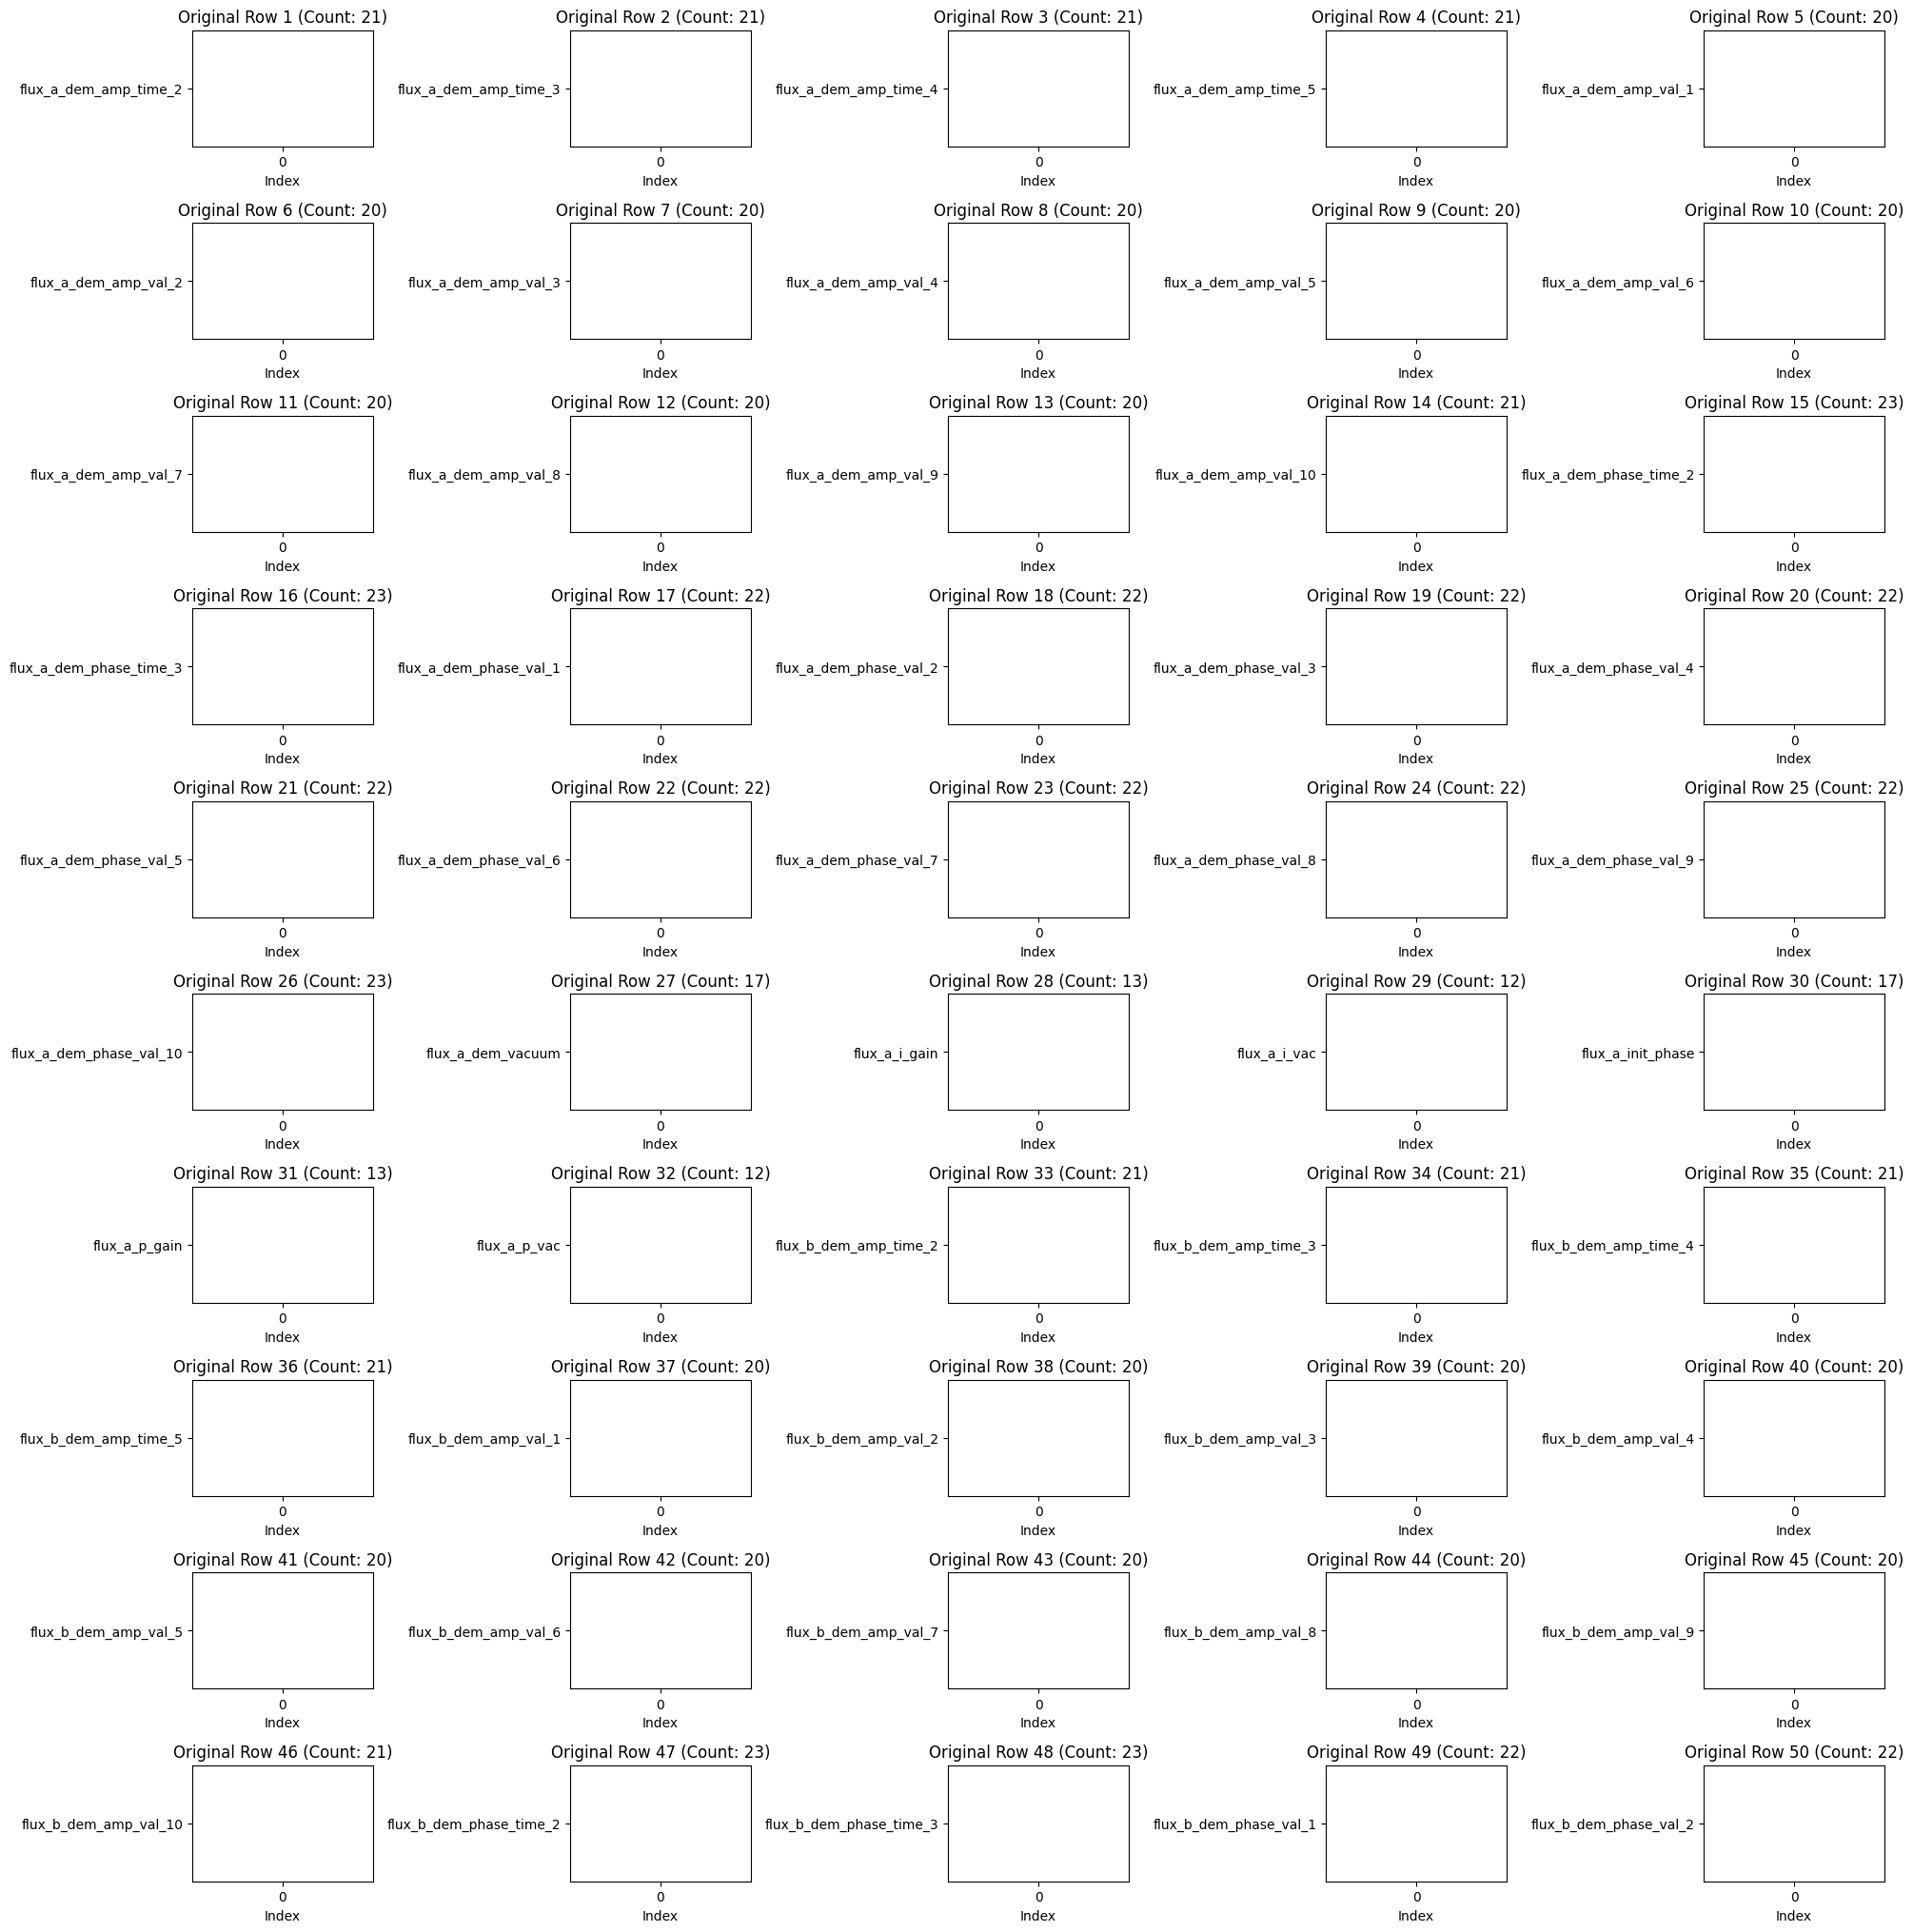

In [ ]:
synthetic_samples = pd.read_csv('v13_synthetic_samples.csv')
original_data = pd.read_csv('/Users/r/Documents/SAPIENTAI/UNET_conda/Data/training_data.csv')
original_data = original_data.loc[:, original_data.nunique() != 1].dropna()

# Find the min and max of each column in original_data
min_values = original_data.min()
max_values = original_data.max()

# Apply the scaling to the synthetic_samples
for column in synthetic_samples.columns:
    synthetic_samples[column] = synthetic_samples[column] * (max_values[column] - min_values[column]) + min_values[column]

synthetic_samples.to_csv('v13_synthetic_OGscale.csv', index=False)




num_rows_to_plot = 50
selected_rows = original_data[:num_rows_to_plot]

def plot_data(dataset, cols=5):
    num_samples = len(dataset)
    plt.figure(figsize=(20, 2 * (num_samples // cols + 1)))
    for i, data in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.plot(data)
        # plt.scatter(range(len(data)), data)  # Use scatter plot instead of plot
        point_count = len(data)
        plt.title(f'Original Row {i+1} (Count: {point_count})')  # Display point count in the title
        plt.xticks(np.arange(0, len(data), 50))
        plt.xlabel('Index')

plot_data(selected_rows, cols=5)
plt.tight_layout()
plt.show()